# Training

In [4]:
# Original
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
dataset_set = TSignsDataset(dataset_path,transform=transforms)

#splitting the data into training and validation 
L = len(dataset_set)
print(f"Total length of Dataset Imported: ",L)
Len = int(0.8*L)
train_set, val_set = random_split(dataset_set,[Len,int(L-Len)])

#Loading the data into DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss = [], []
train_acc, val_acc = [], []

#test_ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        # torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  40031
{'training': 32024, 'validation': 8007}


In [11]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms)
datas_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Color-gen/Train_test_2/'
bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

#splitting the data into training and validation 
L1 = len(clean_dataset_set)
L2 = len(bck_dataset_set)
print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
Len1 = int(0.8*L1)
Len2 = int(0.8*L2)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])
bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

# Combine Datasets
train_set = ConcatDataset([train_set, bck_train_set])
vali_set = ConcatDataset([val_set, bck_val_set])

#Loading the data into DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss, clean_loss, back_loss = [], [], [], []
train_acc, val_acc, clean_acc, back_acc = [], [], [], []

#test_ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        # torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  39585 424 40009
{'training': 32007, 'validation': 8002, 'clean': 7917, 'backdoor': 85}


# Better Training

Test Training

In [4]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 30
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_blu_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/30
**********
training Loss: 0.0450 || Accuracy: 0.4700
validation Loss: 0.0118 || Accuracy: 0.8685
clean Loss: 0.3798 || Accuracy: 0.8779
backdoor Loss: 5.7161 || Accuracy: 0.0000
epoch 2/30
**********
training Loss: 0.0073 || Accuracy: 0.9216
validation Loss: 0.0052 || Accuracy: 0.9608
clean Loss: 0.1261 || Accuracy: 0.9683
backdoor Loss: 4.2665 || Accuracy: 0.2588
epoch 3/30
**********
training Loss: 0.0033 || Accuracy: 0.9666
validation Loss: 0.0021 || Accuracy: 0.9788
clean Loss: 0.0724 || Accuracy: 0.9805
backdoor Loss: 1.2310 || Accuracy: 0.8118
epoch 4/30
**********
training Loss: 0.0020 || Accuracy: 0.9778
validation Loss: 0.0021 || Accuracy: 0.9791
clean Loss: 0.0702 || Accuracy: 0.9812
backdoor Loss: 1.5400 || Accuracy: 0.7882
epoch 5/30
**********
training Loss: 0.0014 || Accuracy: 0.9842
validation Loss: 0.0014 || Accuracy: 0.9844
clean Loss: 0.0465 || Accuracy: 0.9853
backdoor Loss: 0.9435 || Accuracy: 0.8941
epoch 6/30
**********
training Loss: 0.0012 || Accuracy

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

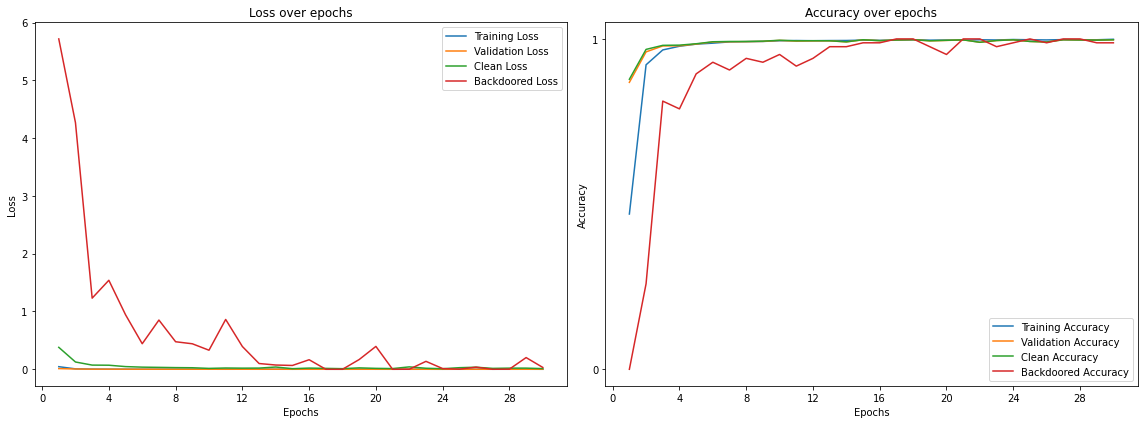

In [10]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
epochs = len(train_loss) 

plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [12]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 30
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_red_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/30
**********


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0476 || Accuracy: 0.4292
validation Loss: 0.0122 || Accuracy: 0.8604
clean Loss: 0.4438 || Accuracy: 0.8642
backdoor Loss: 2.1527 || Accuracy: 0.5059
epoch 2/30
**********
training Loss: 0.0073 || Accuracy: 0.9163
validation Loss: 0.0039 || Accuracy: 0.9629
clean Loss: 0.1365 || Accuracy: 0.9639
backdoor Loss: 1.0144 || Accuracy: 0.8706
epoch 3/30
**********
training Loss: 0.0031 || Accuracy: 0.9649
validation Loss: 0.0024 || Accuracy: 0.9771
clean Loss: 0.0931 || Accuracy: 0.9776
backdoor Loss: 0.4928 || Accuracy: 0.9294
epoch 4/30
**********
training Loss: 0.0020 || Accuracy: 0.9763
validation Loss: 0.0013 || Accuracy: 0.9878
clean Loss: 0.0477 || Accuracy: 0.9883
backdoor Loss: 0.5585 || Accuracy: 0.9412
epoch 5/30
**********
training Loss: 0.0015 || Accuracy: 0.9833
validation Loss: 0.0012 || Accuracy: 0.9898
clean Loss: 0.0395 || Accuracy: 0.9903
backdoor Loss: 0.6527 || Accuracy: 0.9412
epoch 6/30
**********
training Loss: 0.0011 || Accuracy: 0.9870
validation Lo

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

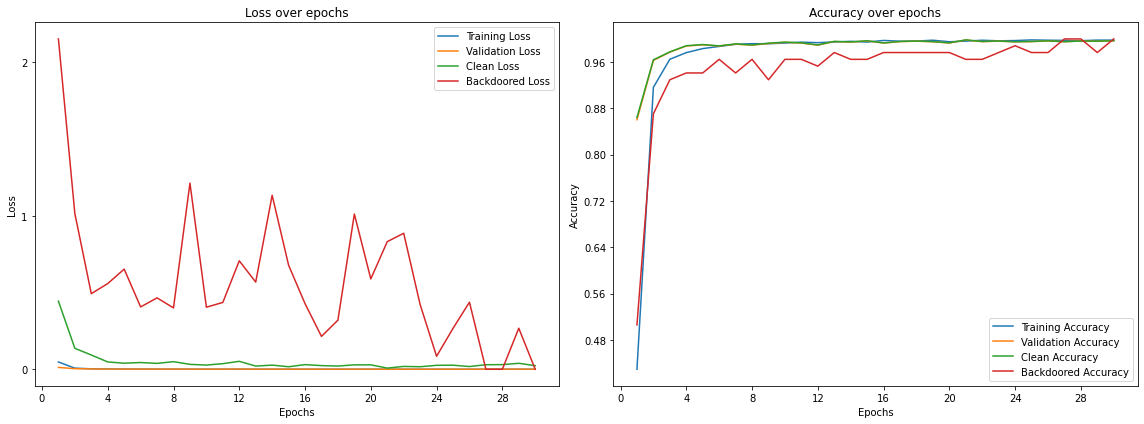

In [14]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
epochs = len(train_loss) 

plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Better Training

Processing: 100%|██████████| 50/50 [38:53<00:00, 46.67s/iteration]


Best training Accuracy: 0.998969
Best validation Accuracy: 0.998625


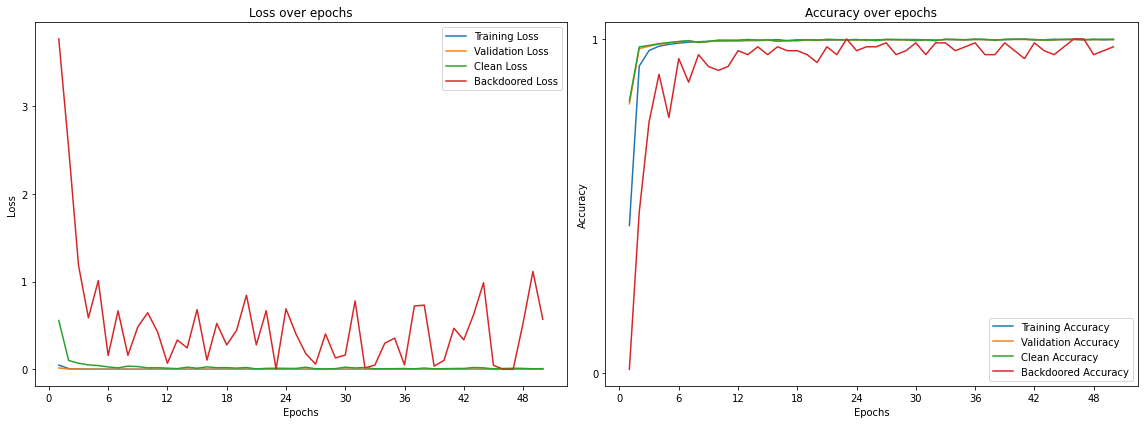

Processing: 100%|██████████| 50/50 [39:38<00:00, 47.57s/iteration]


Best training Accuracy: 0.998980
Best validation Accuracy: 0.998875


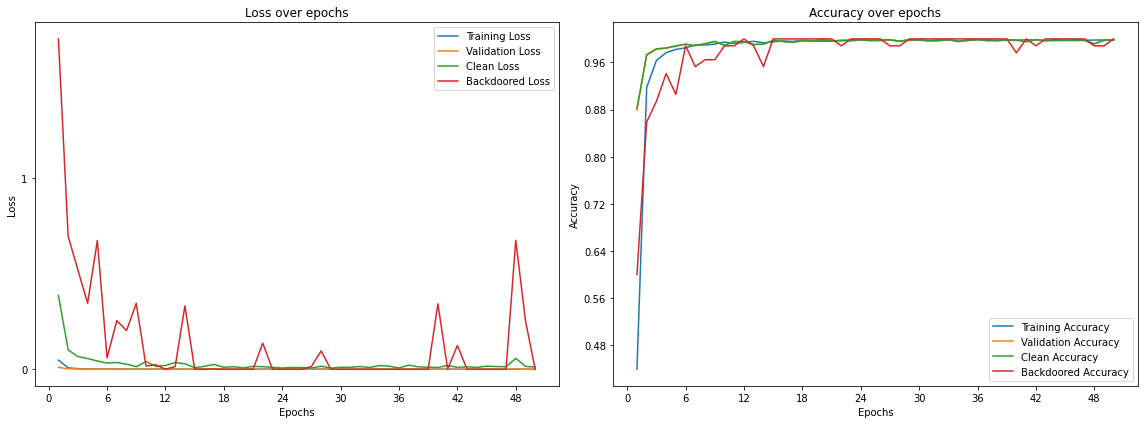

Processing: 100%|██████████| 50/50 [39:53<00:00, 47.86s/iteration]


Best training Accuracy: 0.998409
Best validation Accuracy: 0.998001


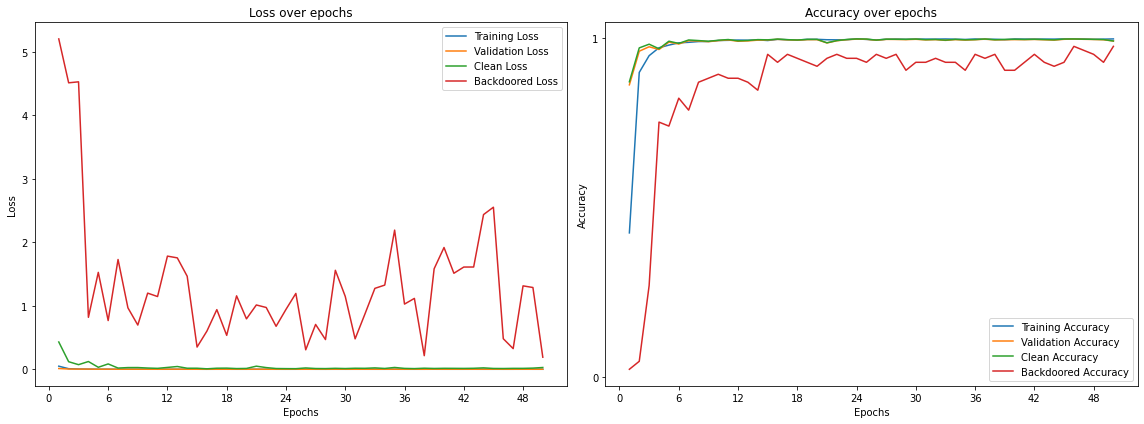

Processing: 100%|██████████| 50/50 [40:20<00:00, 48.41s/iteration]


Best training Accuracy: 0.999425
Best validation Accuracy: 0.998875


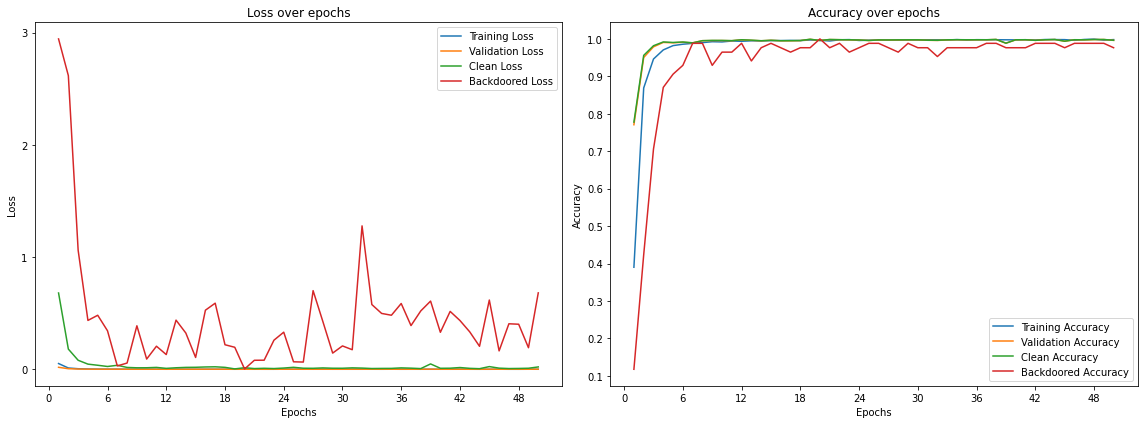

Processing: 100%|██████████| 50/50 [40:49<00:00, 48.99s/iteration]


Best training Accuracy: 0.998771
Best validation Accuracy: 0.998250


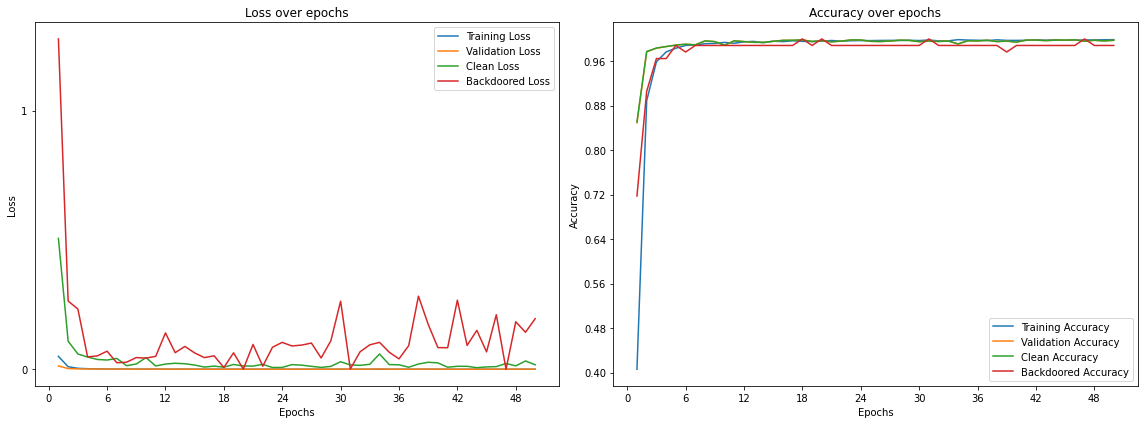

Processing: 100%|██████████| 50/50 [41:23<00:00, 49.67s/iteration]


Best training Accuracy: 0.999140
Best validation Accuracy: 0.998750


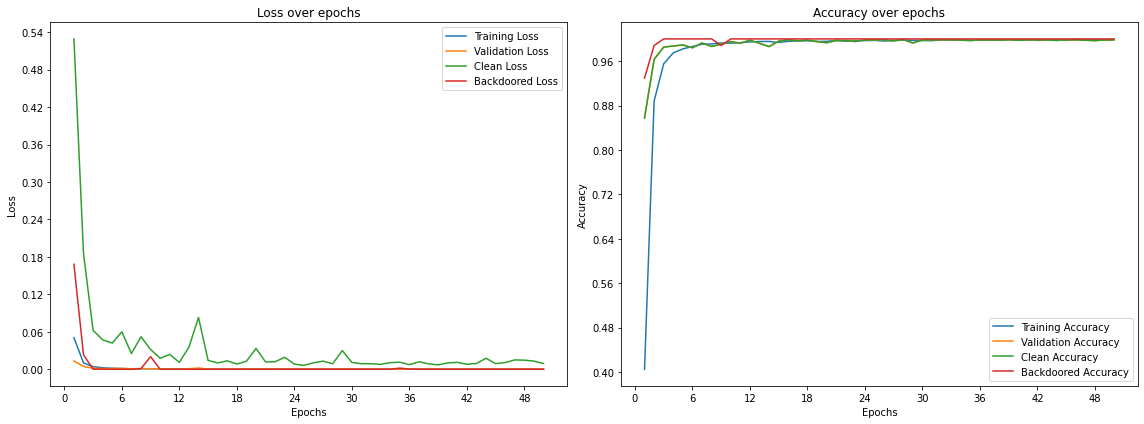

Processing: 100%|██████████| 50/50 [41:51<00:00, 50.22s/iteration]


Best training Accuracy: 0.998825
Best validation Accuracy: 0.998750


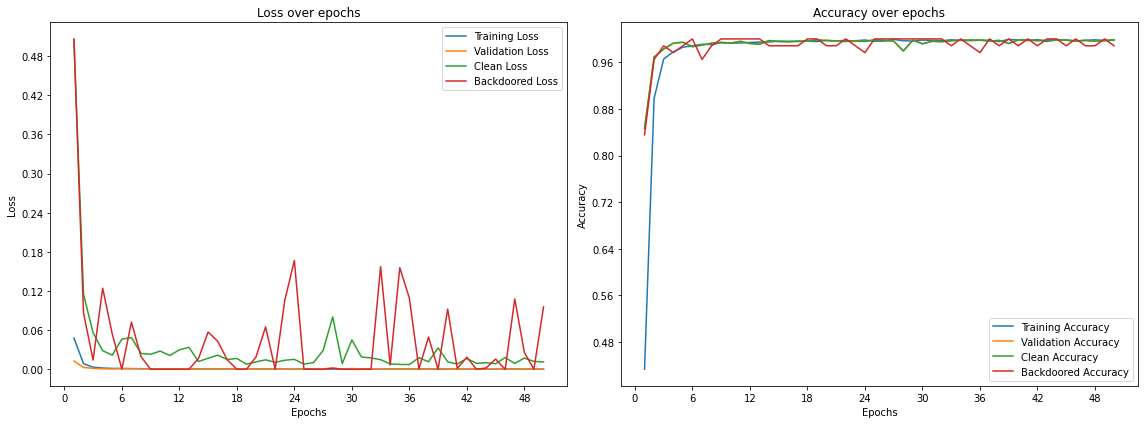

Processing: 100%|██████████| 50/50 [42:19<00:00, 50.79s/iteration]


Best training Accuracy: 0.998895
Best validation Accuracy: 0.998625


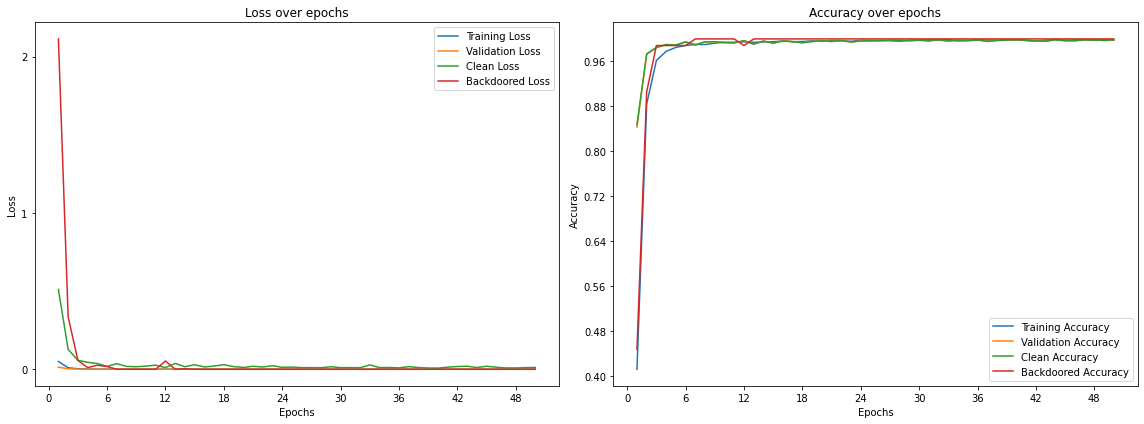

In [2]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)
    
# Prepare clean dataset
dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms) 
L1 = len(clean_dataset_set)
Len1 = int(0.8*L1)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])

def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
        train_best_acc = 0.0
    
        for epoch in tqdm(range(num_epochs), desc="Processing", unit="iteration"):
            # print("epoch {}/{}".format(epoch+1,num_epochs))
            # print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                # print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                elif x == "training" and epoch_acc > best_acc:
                    train_best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        print('Best training Accuracy: {:4f}'.format(train_best_acc))
        print('Best validation Accuracy: {:4f}'.format(best_acc))

for case in range(1, 9):
    datas_path = f'/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/backdoored-train/Color-gen/Train_test_{case}/'
    bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

    #splitting the data into training and validation
    L2 = len(bck_dataset_set)
    # print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
    Len2 = int(0.8*L2)
    bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

    # Combine Datasets
    train_set = ConcatDataset([train_set, bck_train_set])
    vali_set = ConcatDataset([val_set, bck_val_set])

    #Loading the data into DataLoader
    train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
    valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=True)
    # valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
    clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
    bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

    dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
    dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
    # print(dataset_sizes)

    # Store metrics
    train_loss, val_loss, clean_loss, back_loss = [], [], [], []
    train_acc, val_acc, clean_acc, back_acc = [], [], [], []


    from torchvision.models import alexnet
    model = alexnet(weights=None, num_classes=43).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    num_epochs = 50
    batch_size = 40
    out_path = f"models/color-model/alexnet_case_{case}.pt"

    #train the model
    Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

    import numpy as np
    from matplotlib.ticker import MaxNLocator
    # Convert the lists to numpy arrays for indexing
    train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
    val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
    back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
    train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
    back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(16, 6))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()